# Importation des données

In [1]:
import os
import string
import re
import math
from math import sqrt
import numpy as np
import random
import time
import pandas as pd
import nltk, re, pprint
#nltk.download('punkt')
from nltk import word_tokenize
random.seed(1)

import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

import pickle

os.chdir('/Users/alainquartierlatente/Desktop/Ensae/StatApp')

with open("data/corpus_trie.file", "rb") as f:
    corpus = pickle.load(f) 
ens_tweets = [phrase.split() for phrase in corpus]
len(ens_tweets)

1344097

On ne garde ici que les 10 000 premiers tweets

In [2]:
phrases = ens_tweets[0:10000]

In [3]:
words = [item for sublist in phrases for item in sublist]
print(type(words))
vocabulary = list(dict.fromkeys(words))
with open("data/10k/vocabulary.file", "wb") as f:
    pickle.dump(vocabulary, f, pickle.HIGHEST_PROTOCOL)
print("Nombre de mots :", len(words))
print("Taille du vocabulaire :", len(vocabulary))

<class 'list'>
Nombre de mots : 110348
Taille du vocabulaire : 11377


Les 10 mots les plus communs sont :
[('nickname', 7918), ('de', 4002), ('le', 2589), ('est', 2176), ('je', 2052), ('les', 1827), ('j', 1809), ('à', 1743), ('c', 1714), ('la', 1643)]


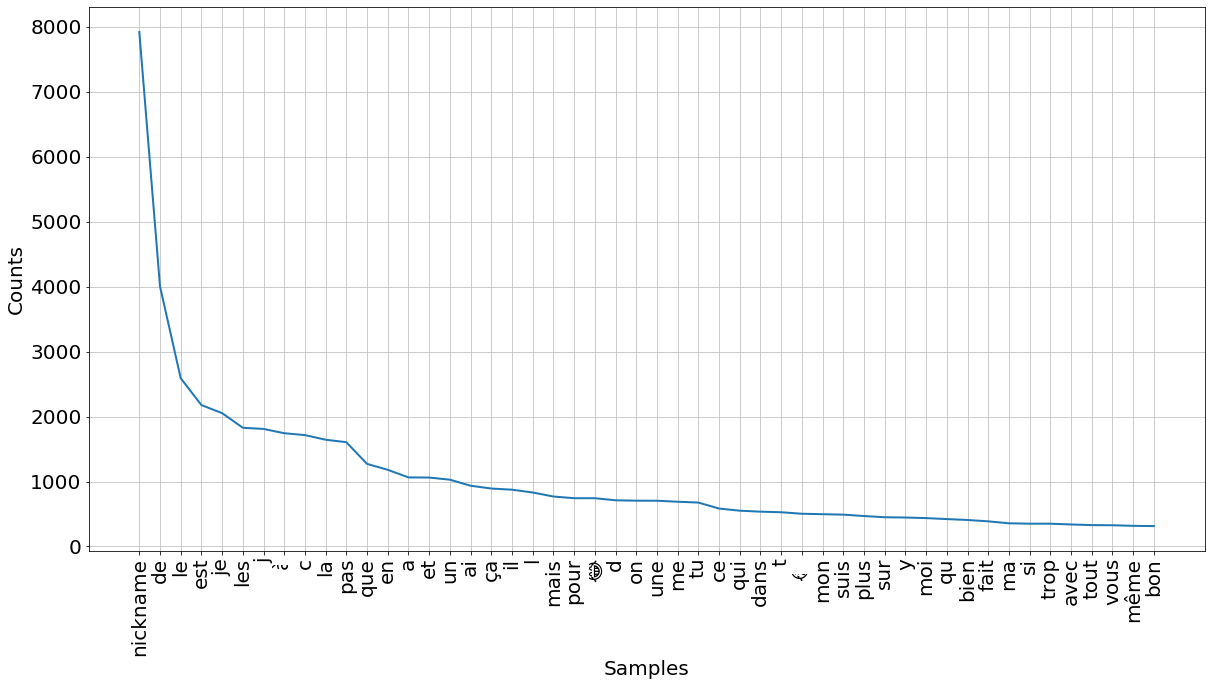

In [4]:
# Pour changer la taille des graphiques :
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["font.size"] = 20

fdist = nltk.FreqDist(words)
print("Les 10 mots les plus communs sont :")
print(fdist.most_common(10))
fdist.plot(50)

In [5]:
# Fonction pour mettre à jour le graphique en direct
def live_plot(data, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.plot(data)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.show();

# Sampling rate et negative sampling
On va simplifier un peu le corpus en enlevant certains mots. Pour cela on va faire un sous-échantillonnage du corpus pour supprimer certains mots. 

Pour chaque mot $w_i$ on note $z(w_i)$ la proportion d'apparition de ce mot, c'est-à-dire le rapport entre le nombre de fois que ce mot apparait et le nombre total de mots. La probabilité de garder un mot le mot $w_i$ est :
$$
\mathbb P(w_i) = \left(\sqrt{\frac{z(w_i)}{q}} + 1 \right)
\times
\frac{q}{z(w_i)}
$$
Le paramètre $q$ est appelé "sample" – échantillonnage – contrôle le nombre de sous-échantillonnages. La valeur par défaut est 0,001.

In [10]:
def calcul_proba(x):
    result = (sqrt(x)+1)*(1/x)
    return(result)
calcul_proba_v = np.vectorize(calcul_proba) # Pour vectoriser la fonction
# Fonction pour créer l'échantillon
def creer_echantillon(phrases, mot_index ,probabilities_subsampling,  window = 2):
    #Sub-sampling
    def sub_sampling(phrase):
        res = []
        for word in phrase: #et pour tous les mots de l'article
        # Les mots à supprimer sont les mots tels que la loi générée U([0,1]) soit > proba
        # On garde donc les mots si U([0,1]) <= proba
            proba_w = probabilities_subsampling[mot_index[word]]
            if np.random.uniform(low=0.0, high=1.0) <= proba_w: # Je garde le mot
                res.append(word)
        return(res)
    nouveau_corpus = list(map(sub_sampling, phrases)) 
    #nouveau_corpus = Parallel(n_jobs=num_cores)(delayed(sub_sampling)(phrase) for phrase in phrases)

    phrases = [phrase for phrase in nouveau_corpus if len(phrase)>1] # On enlève les phrases avec 1 seul mot
    def tirage_f_c(phrase):
        # Pour chaque phrase on prend au hasard un mot focus et un mot contexte
        focus = np.random.randint(0, len(phrase))
        contexte = np.random.randint(max(focus-window,0),
                                       min(focus+window+1, len(phrase)))
        while(contexte == focus):
            contexte = np.random.randint(max(focus-window,0),
                                       min(focus+window+1, len(phrase)))
        index_i = mot_index[phrase[focus]]
        index_j = mot_index[phrase[contexte]]
        return([index_i, index_j])
    #test_sample = Parallel(n_jobs=num_cores)(delayed(tirage_f_c)(phrase) for phrase in phrases)
    test_sample = map(tirage_f_c, phrases)
    return(list(test_sample))

sample = 0.001
index_mot = {index: w for (index, w) in enumerate(vocabulary)}
mot_index = {w: index for (index, w) in enumerate(vocabulary)}
proportion = np.array([(fdist[w]/ (len(words) * sample)) for w in vocabulary])
p_subsampling = calcul_proba_v(proportion) # C'est le vecteur contenant les proba de sub-sampling

Pour le négative sampling, la probabilité de garder le mot $w_i$ est égale à :
$$
\mathbb P(w_i) = \frac{f(w_i)^{3/4}}{
\sum_{j=1}^n f(w_j)^{3/4}
}
$$
Avec $f(w_j)$ la fréquence d'apparition du mot $w_j$.

In [11]:
p_negativesampling = np.array([(fdist[w]**(3/4)) for w in vocabulary])
p_negativesampling /= p_negativesampling.sum()

In [12]:
# Fonction de tirage des mots du negative sampling
def tirage_neg_sampling(vocabulary, proba_negativesampling, focus, context, K = 5):
    #proba_negativesampling[focus] = 0
    #proba_negativesampling[context] = 0
    liste_vocab = list(range(len(vocabulary)))
    neg_sampling = np.random.choice(liste_vocab, size=K, p=proba_negativesampling)
   # while( (focus in neg_sampling) | (context in neg_sampling)):
   #     neg_sampling = np.random.choice(liste_vocab, size=K, p=proba_negativesampling)
    return(neg_sampling)

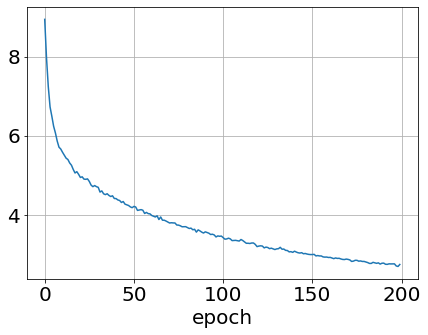

0.37
100.25


In [14]:
dim = 20
epoch = 200
learning_rate = 0.01
sample = 0.001
window = 3
K = 5
plot = True

input = torch.randn(len(vocabulary), dim)
output = torch.randn(len(vocabulary), dim)
input = autograd.Variable(input, requires_grad=True)
output = autograd.variable(output, requires_grad=True)

loss_tot = []
temps_par_epoch = []

start = time.time()
for i in range(epoch):
    #print(i)
    loss_val = 0
    start_epoch = time.time()
    test_sample = creer_echantillon(phrases, mot_index, p_subsampling, window)
    for focus, context in test_sample:
        neg_sample = tirage_neg_sampling(vocabulary, p_negativesampling,
                                         focus, context,
                                         K = K)
        #vect_sample = np.append(context, neg_sample)
        data = torch.matmul(input[focus,], torch.t(output[context,]))
        loss1 = - F.logsigmoid(data)

        data = torch.matmul(input[focus,], torch.t(output[neg_sample,]))
        loss2 = - F.logsigmoid(-data).sum()
        #print(loss)
        loss_val += loss1 + loss2
        # Pour ensuite dériver les matrices par rapport à la loss
        (loss1+loss2).backward()

        # Il faut modifier juste le .data pour ne pas perdre la structure
        input.data = input.data - learning_rate * input.grad.data
        output.data = output.data - learning_rate * output.grad.data

        input.grad.data.zero_()
        output.grad.data.zero_()
    with open("data/10k/input_%i.file" %(len(loss_tot)+1), "wb") as f:
        pickle.dump(input, f, pickle.HIGHEST_PROTOCOL)
    with open("data/10k/output_%i.file" %(len(loss_tot)+1), "wb") as f:
        pickle.dump(output, f, pickle.HIGHEST_PROTOCOL)
    with open("data/10k/loss.file", "wb") as f:
        pickle.dump(loss_tot, f, pickle.HIGHEST_PROTOCOL)
    with open("data/10k/temps_par_epoch.file", "wb") as f:
        pickle.dump(temps_par_epoch, f, pickle.HIGHEST_PROTOCOL)

    end_epoch = time.time()
    temps_par_epoch.append(end_epoch - start_epoch)
    loss_val = loss_val / len(vocabulary)
    loss_tot.append(loss_val)
    if plot:
        live_plot(loss_tot)
    print(round((end_epoch - start_epoch)/60, 2))

end = time.time()
print(round((end - start)/60, 2))

Si on veut encore refaire tourner :

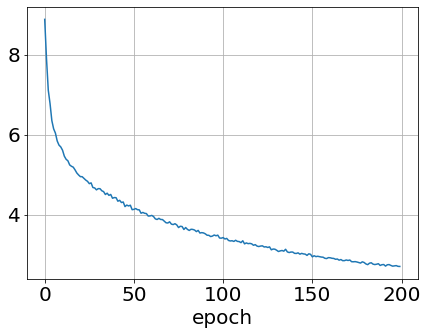

38.19


In [11]:
start = time.time()
for i in range(100):
    #print(i)
    loss_val = 0
    start_epoch = time.time()
    test_sample = creer_echantillon(phrases, mot_index, p_subsampling, window)
    for focus, context in test_sample:
        neg_sample = tirage_neg_sampling(vocabulary, p_negativesampling,
                                         focus, context,
                                         K = K)
        #vect_sample = np.append(context, neg_sample)
        data = torch.matmul(input[focus,], torch.t(output[context,]))
        loss1 = - F.logsigmoid(data)

        data = torch.matmul(input[focus,], torch.t(output[neg_sample,]))
        loss2 = - F.logsigmoid(-data).sum()
        #print(loss)
        loss_val += loss1 + loss2
        # Pour ensuite dériver les matrices par rapport à la loss
        (loss1+loss2).backward()

        # Il faut modifier juste le .data pour ne pas perdre la structure
        input.data = input.data - learning_rate * input.grad.data
        output.data = output.data - learning_rate * output.grad.data

        input.grad.data.zero_()
        output.grad.data.zero_()
        
    with open("data/input_10k.file", "wb") as f:
        pickle.dump(input, f, pickle.HIGHEST_PROTOCOL)
    with open("data/output_10k.file", "wb") as f:
        pickle.dump(output, f, pickle.HIGHEST_PROTOCOL)
    end_epoch = time.time()
    temps_par_epoch.append(end_epoch - start_epoch)
    print(round((end_epoch - start_epoch)/60, 2))
    loss_val = loss_val / len(vocabulary)
    loss_tot.append(loss_val)
    if plot:
        live_plot(loss_tot)
end = time.time()
print(round((end - start)/60, 2))

Tests de temps de calcul

In [101]:
start = (time.time()) # 17:35:45
test_sample = creer_echantillon(phrases, mot_index, p_subsampling, window)
end = (time.time())
print((end-start)/60)

ok subsampling
1.7104214509328206


In [100]:
start = (time.time()) # 16:37


tirage_neg_sampling(vocabulary, p_negativesampling,
                                         test_sample[0][0], test_sample[0][1],
                                         K = K)
end = (time.time())
print((end-start)/60)

0.0001298983891805013


In [15]:
with open("data/10k/input.file", "wb") as f:
    pickle.dump(input, f, pickle.HIGHEST_PROTOCOL)
with open("data/10k/output.file", "wb") as f:
    pickle.dump(output, f, pickle.HIGHEST_PROTOCOL)
with open("data/10k/vocabulary.file", "wb") as f:
    pickle.dump(vocabulary, f, pickle.HIGHEST_PROTOCOL)